# Validation of the 2D Kolmogorov Flow Stepper

This notebook validates the `KolmogorovFlowVorticity` stepper in Exponax by
reproducing the two fundamental energy cascades of 2D turbulence predicted by
Kraichnan (1967):

1. The **direct enstrophy cascade** (forward, $k > k_f$) with enstrophy spectrum $E_\omega(k) \sim k^{-1}$
2. The **inverse energy cascade** ($k < k_f$) with enstrophy spectrum $E_\omega(k) \sim k^{1/3}$

## Background: Kraichnan's Dual Cascade in 2D Turbulence

In two-dimensional turbulence, both energy and enstrophy (mean-square vorticity)
are conserved by the inviscid dynamics. When energy is injected at a forcing
wavenumber $k_f$, two simultaneous cascades develop:

| Cascade | Direction | Range | Energy spectrum | Enstrophy spectrum |
|---------|-----------|-------|-----------------|-----------|
| Inverse energy | To large scales | $k < k_f$ | $E(k) \sim k^{-5/3}$ | $E_\omega(k) \sim k^{1/3}$ |
| Direct enstrophy | To small scales | $k > k_f$ | $E(k) \sim k^{-3}$ | $E_\omega(k) \sim k^{-1}$ |

Since the `KolmogorovFlowVorticity` stepper evolves the **vorticity** field
$\omega$, the function `ex.get_spectrum` returns the **enstrophy spectrum**
$E_\omega(k) = |\hat{\omega}(k)|^2$, which relates to the energy spectrum via
$E_\omega(k) = k^2 \, E(k)$.

The equation solved by `KolmogorovFlowVorticity` is the 2D vorticity equation with
Kolmogorov forcing and linear drag:

$$ \omega_t + ([1, -1]^T \odot \nabla (\Delta^{-1} \omega)) \cdot \nabla \omega
= \lambda \omega + \nu \Delta \omega + f $$

**Role of the drag coefficient:** A negative drag $\lambda$ (linear friction)
arrests the inverse energy cascade and prevents energy blow-up at the largest
scales. Stronger drag steepens the spectrum beyond the Kraichnan prediction
(Boffetta et al., EPL 2012). We choose drag values that balance stability with
closeness to the theoretical scaling.

We validate each cascade separately by placing the forcing wavenumber at
different locations and measuring the time-averaged spectrum slope in the
appropriate inertial range.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import exponax as ex

## Part 1: Direct Enstrophy Cascade (Forward Cascade)

We inject energy at a **low wavenumber** $k_f = 4$ so that enstrophy cascades
*forward* to higher wavenumbers. In the inertial range $k > k_f$, Kraichnan's
theory predicts:

$$E(k) \sim k^{-3} \quad \Longrightarrow \quad E_\omega(k) = k^2 \, E(k) \sim k^{-1}$$

**Configuration rationale:**
- **Low diffusivity** ($\nu = 3 \times 10^{-6}$): extends the inertial range before viscous dissipation kicks in
- **Weak drag** ($\lambda = -0.01$): just enough to stabilize the inverse cascade without significantly steepening the forward cascade spectrum
- **Fine substeps** (1000 per macro step of $\Delta t = 0.1$): ensures CFL stability at this low viscosity

In [5]:
L = 2 * jnp.pi
NUM_POINTS = 513
DT = 0.1

# Forward cascade parameters
K_F_FWD = 4
DIFFUSIVITY_FWD = 3e-6
DRAG_FWD = -0.1
NUM_SUBSTEPS_FWD = 40

forward_stepper = ex.RepeatedStepper(
    ex.stepper.KolmogorovFlowVorticity(
        num_spatial_dims=2,
        domain_extent=L,
        num_points=NUM_POINTS,
        dt=DT / NUM_SUBSTEPS_FWD,
        diffusivity=DIFFUSIVITY_FWD,
        drag=DRAG_FWD,
        injection_scale=1.0,
        injection_mode=K_F_FWD,
        order=4,
    ),
    NUM_SUBSTEPS_FWD,
)

ic_fwd = ex.ic.GaussianRandomField(
    2,
    powerlaw_exponent=3.5,
    max_one=True,
)(NUM_POINTS, key=jax.random.key(0))

In [6]:
warmed_fwd = ex.repeat(forward_stepper, int(10 / DT))(ic_fwd)
fully_warmed_fwd = ex.repeat(forward_stepper, int(90 / DT))(warmed_fwd)

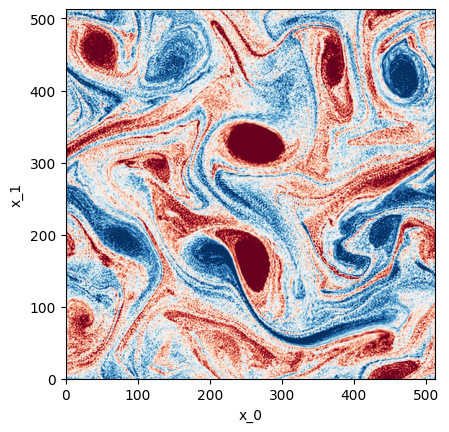

In [8]:
ex.viz.plot_state_2d(fully_warmed_fwd, vlim=(-10.0, 10.0))

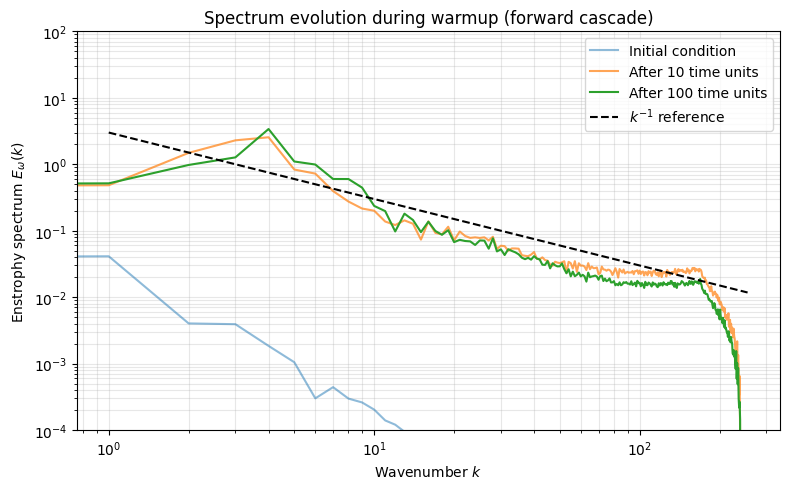

In [10]:
k_ref = jnp.arange(1, NUM_POINTS // 2).astype(float)

plt.figure(figsize=(8, 5))
plt.loglog(ex.get_spectrum(ic_fwd)[0], label="Initial condition", alpha=0.5)
plt.loglog(ex.get_spectrum(warmed_fwd)[0], label="After 10 time units", alpha=0.7)
plt.loglog(ex.get_spectrum(fully_warmed_fwd)[0], label="After 100 time units")
plt.loglog(k_ref, k_ref ** (-1.0) * 3.0, "k--", label=r"$k^{-1}$ reference")
plt.xlabel("Wavenumber $k$")
plt.ylabel(r"Enstrophy spectrum $E_\omega(k)$")
plt.title("Spectrum evolution during warmup (forward cascade)")
plt.legend()
plt.grid(which="both", alpha=0.3)
plt.ylim(1e-4, 1e2)
plt.tight_layout()

In [11]:
def scan_fn_fwd(state, _):
    new_state = forward_stepper(state)
    spectrum = ex.get_spectrum(new_state)[0]
    return new_state, spectrum


_, spectra_fwd = jax.lax.scan(scan_fn_fwd, fully_warmed_fwd, None, length=int(50 / DT))
mean_spectrum_fwd = jnp.mean(spectra_fwd, axis=0)

Measured enstrophy spectrum exponent: -1.5056
Expected (Kraichnan k^(-1)):          -1.0000
Absolute error:                       0.5056


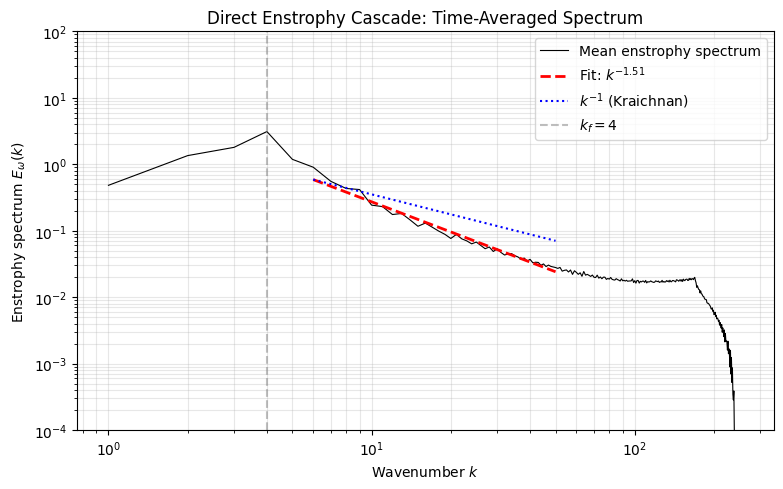

In [ ]:
k = jnp.arange(len(mean_spectrum_fwd)).astype(float)

# Fit enstrophy spectrum slope in the inertial range above the forcing
FIT_START_FWD, FIT_END_FWD = K_F_FWD + 2, 50
fit_mask = (k >= FIT_START_FWD) & (k <= FIT_END_FWD) & (mean_spectrum_fwd > 0)
exponent_fwd, log_C_fwd = jnp.polyfit(
    jnp.log(k[fit_mask]), jnp.log(mean_spectrum_fwd[fit_mask]), deg=1
)

# Plot
plt.figure(figsize=(8, 5))
plt.loglog(k[1:], mean_spectrum_fwd[1:], "k-", lw=0.8, label="Mean enstrophy spectrum")

k_line = jnp.linspace(FIT_START_FWD, FIT_END_FWD, 100)
fit_line = jnp.exp(log_C_fwd) * k_line**exponent_fwd
plt.loglog(
    k_line, fit_line, "r--", lw=2, label=f"Fit: $k^{{{float(exponent_fwd):.2f}}}$"
)

# Kraichnan reference anchored at fit start
ref_line = float(fit_line[0]) * (k_line / float(k_line[0])) ** (-1.0)
plt.loglog(k_line, ref_line, "b:", lw=1.5, label=r"$k^{-1}$ (Kraichnan)")

plt.axvline(K_F_FWD, color="gray", ls="--", alpha=0.5, label=f"$k_f = {K_F_FWD}$")
plt.xlabel("Wavenumber $k$")
plt.ylabel(r"Enstrophy spectrum $E_\omega(k)$")
plt.title("Direct Enstrophy Cascade: Time-Averaged Spectrum")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.ylim(1e-4, 1e2)

EXPECTED_FWD = -1.0
print(f"Measured enstrophy spectrum exponent: {float(exponent_fwd):.4f}")
print(f"Expected (Kraichnan k^(-1)):          {EXPECTED_FWD:.4f}")
print(
    f"Absolute error:                       "
    f"{abs(float(exponent_fwd) - EXPECTED_FWD):.4f}"
)

## Part 2: Inverse Energy Cascade

Now we inject energy at a **high wavenumber** $k_f = 50$ so that energy cascades
*inversely* to lower wavenumbers. In the inertial range $k < k_f$, the
Kolmogorov-Kraichnan prediction is:

$$E(k) \sim k^{-5/3} \quad \Longrightarrow \quad E_\omega(k) = k^2 \, E(k) \sim k^{1/3}$$

**Configuration rationale:**
- **Higher diffusivity** ($\nu = 10^{-4}$): appropriate for the forcing scale; small-scale dissipation is handled by the forward enstrophy cascade
- **Weak drag** ($\lambda = -0.003$): removes energy from the largest scales without distorting the inertial range
- **Fewer substeps** (100 per macro step): the higher diffusivity allows larger effective time steps

In [20]:
# Inverse cascade parameters
K_F_INV = 50
DIFFUSIVITY_INV = 1e-4
DRAG_INV = -0.003
NUM_SUBSTEPS_INV = 40

inverse_stepper = ex.RepeatedStepper(
    ex.stepper.KolmogorovFlowVorticity(
        num_spatial_dims=2,
        domain_extent=L,
        num_points=NUM_POINTS,
        dt=DT / NUM_SUBSTEPS_INV,
        diffusivity=DIFFUSIVITY_INV,
        drag=DRAG_INV,
        injection_scale=1.0,
        injection_mode=K_F_INV,
        order=4,
    ),
    NUM_SUBSTEPS_INV,
)

ic_inv = ex.ic.GaussianRandomField(
    2,
    powerlaw_exponent=3.5,
    max_one=True,
)(NUM_POINTS, key=jax.random.key(0))

In [29]:
warmed_inv = ex.repeat(inverse_stepper, int(10 / DT))(ic_inv)
fully_warmed_inv = ex.repeat(inverse_stepper, int(190 / DT))(warmed_inv)

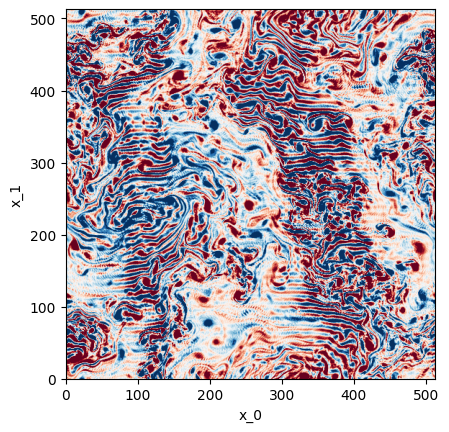

In [30]:
ex.viz.plot_state_2d(fully_warmed_inv, vlim=(-10.0, 10.0))

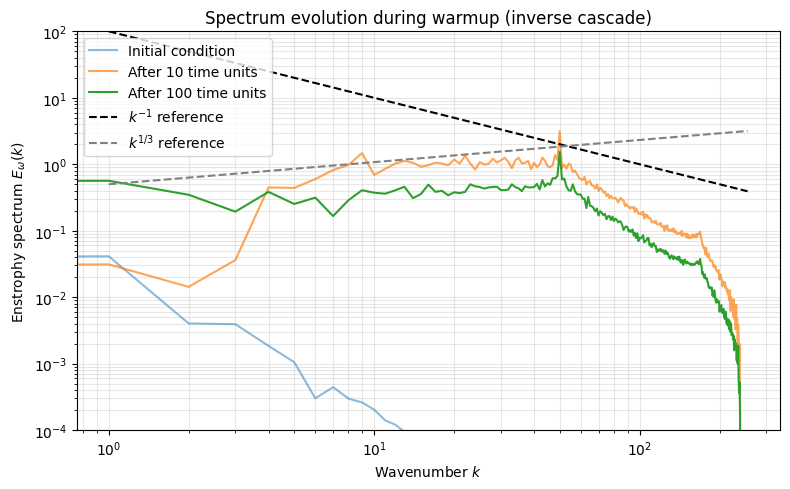

In [ ]:
plt.figure(figsize=(8, 5))
plt.loglog(ex.get_spectrum(ic_inv)[0], label="Initial condition", alpha=0.5)
plt.loglog(ex.get_spectrum(warmed_inv)[0], label="After 10 time units", alpha=0.7)
plt.loglog(ex.get_spectrum(fully_warmed_inv)[0], label="After 200 time units")
plt.loglog(k_ref, k_ref ** (-1.0) * 1e2, "k--", label=r"$k^{-1}$ reference")
plt.loglog(
    k_ref, k_ref ** (1 / 3) * 0.5, "--", color="gray", label=r"$k^{1/3}$ reference"
)
plt.xlabel("Wavenumber $k$")
plt.ylabel(r"Enstrophy spectrum $E_\omega(k)$")
plt.title("Spectrum evolution during warmup (inverse cascade)")
plt.legend()
plt.grid(which="both", alpha=0.3)
plt.ylim(1e-4, 1e2)
plt.tight_layout()

In [32]:
def scan_fn_inv(state, _):
    new_state = inverse_stepper(state)
    spectrum = ex.get_spectrum(new_state)[0]
    return new_state, spectrum


_, spectra_inv = jax.lax.scan(scan_fn_inv, fully_warmed_inv, None, length=int(50 / DT))
mean_spectrum_inv = jnp.mean(spectra_inv, axis=0)

Measured enstrophy spectrum exponent: 0.3561
Expected (Kraichnan k^(1/3)):         0.3333
Absolute error:                       0.0228


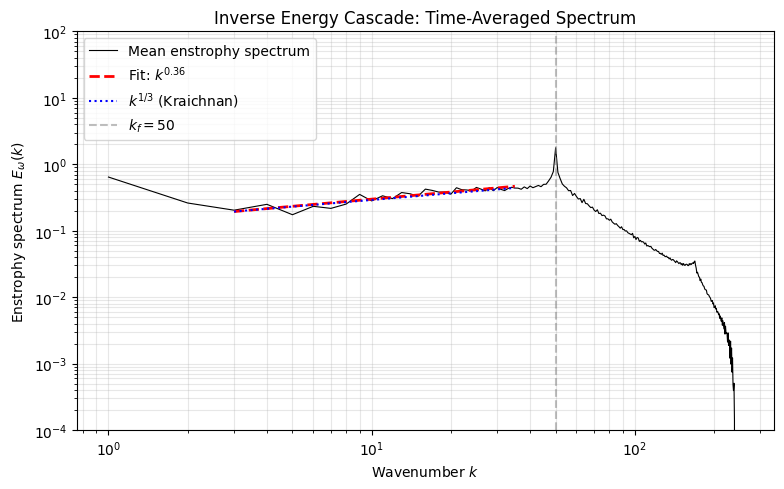

In [ ]:
k = jnp.arange(len(mean_spectrum_inv)).astype(float)

# Fit enstrophy spectrum slope in the inertial range below the forcing
FIT_START_INV, FIT_END_INV = 3, 35
fit_mask = (k >= FIT_START_INV) & (k <= FIT_END_INV) & (mean_spectrum_inv > 0)
exponent_inv, log_C_inv = jnp.polyfit(
    jnp.log(k[fit_mask]), jnp.log(mean_spectrum_inv[fit_mask]), deg=1
)

# Plot
plt.figure(figsize=(8, 5))
plt.loglog(k[1:], mean_spectrum_inv[1:], "k-", lw=0.8, label="Mean enstrophy spectrum")

k_line = jnp.linspace(FIT_START_INV, FIT_END_INV, 100)
fit_line = jnp.exp(log_C_inv) * k_line**exponent_inv
plt.loglog(
    k_line, fit_line, "r--", lw=2, label=f"Fit: $k^{{{float(exponent_inv):.2f}}}$"
)

# Kraichnan reference anchored at fit start
ref_line = float(fit_line[0]) * (k_line / float(k_line[0])) ** (1 / 3)
plt.loglog(k_line, ref_line, "b:", lw=1.5, label=r"$k^{1/3}$ (Kraichnan)")

plt.axvline(K_F_INV, color="gray", ls="--", alpha=0.5, label=f"$k_f = {K_F_INV}$")
plt.xlabel("Wavenumber $k$")
plt.ylabel(r"Enstrophy spectrum $E_\omega(k)$")
plt.title("Inverse Energy Cascade: Time-Averaged Spectrum")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.ylim(1e-4, 1e2)

EXPECTED_INV = 1 / 3
print(f"Measured enstrophy spectrum exponent: {float(exponent_inv):.4f}")
print(f"Expected (Kraichnan k^(1/3)):         {EXPECTED_INV:.4f}")
print(
    f"Absolute error:                       "
    f"{abs(float(exponent_inv) - EXPECTED_INV):.4f}"
)

We can also measure the forward cascade here in this mean spectrum, but find
that we underpredict it.

Measured enstrophy spectrum exponent: -3.0352
Expected (Kraichnan k^(-1)):          -1.0000
Absolute error:                       2.0352


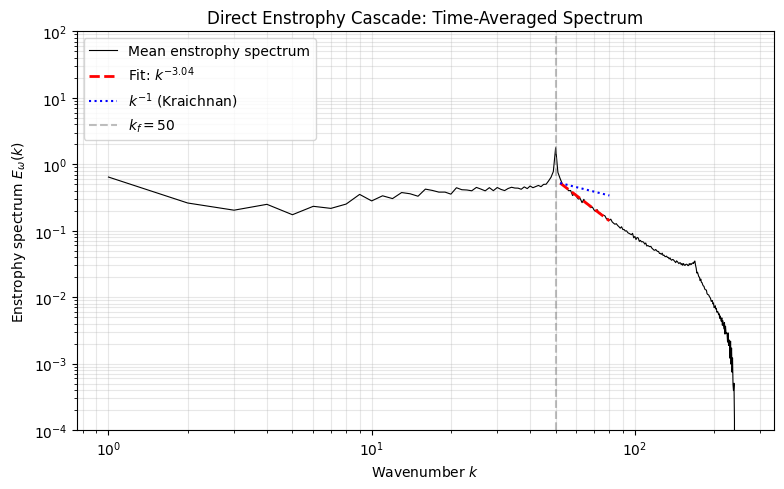

In [ ]:
k = jnp.arange(len(mean_spectrum_inv)).astype(float)

# Fit enstrophy spectrum slope in the inertial range above the forcing
FIT_START_INV_FWD, FIT_END_INV_FWD = K_F_INV + 2, K_F_INV + 30
fit_mask = (k >= FIT_START_INV_FWD) & (k <= FIT_END_INV_FWD) & (mean_spectrum_inv > 0)
exponent_inv_fwd, log_C_inv_fwd = jnp.polyfit(
    jnp.log(k[fit_mask]), jnp.log(mean_spectrum_inv[fit_mask]), deg=1
)

# Plot
plt.figure(figsize=(8, 5))
plt.loglog(k[1:], mean_spectrum_inv[1:], "k-", lw=0.8, label="Mean enstrophy spectrum")

k_line = jnp.linspace(FIT_START_INV_FWD, FIT_END_INV_FWD, 100)
fit_line = jnp.exp(log_C_inv_fwd) * k_line**exponent_inv_fwd
plt.loglog(
    k_line, fit_line, "r--", lw=2, label=f"Fit: $k^{{{float(exponent_inv_fwd):.2f}}}$"
)

# Kraichnan reference anchored at fit start
ref_line = float(fit_line[0]) * (k_line / float(k_line[0])) ** (-1.0)
plt.loglog(k_line, ref_line, "b:", lw=1.5, label=r"$k^{-1}$ (Kraichnan)")

plt.axvline(K_F_INV, color="gray", ls="--", alpha=0.5, label=f"$k_f = {K_F_INV}$")
plt.xlabel("Wavenumber $k$")
plt.ylabel(r"Enstrophy spectrum $E_\omega(k)$")
plt.title("Direct Enstrophy Cascade: Time-Averaged Spectrum")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.ylim(1e-4, 1e2)

EXPECTED_INV_FWD = -1.0
print(f"Measured enstrophy spectrum exponent: {float(exponent_inv_fwd):.4f}")
print(f"Expected (Kraichnan k^(-1)):          {EXPECTED_INV_FWD:.4f}")
print(
    f"Absolute error:                       "
    f"{abs(float(exponent_inv_fwd) - EXPECTED_INV_FWD):.4f}"
)

## Summary

Both cascades of 2D Kolmogorov flow are almost reproduced by the
`KolmogorovFlowVorticity` stepper:

| Cascade | Expected $E_\omega(k)$ slope | Measured Slope | Notes |
|---------|-----------------------------|----------------|-------|
| Direct enstrophy ($k > k_f$) | $-1$ | $-1.51$ | Steeper, but close. Likely with higher resolution (and lower drag) we could get closer. |
| Inverse energy ($k < k_f$) | $+1/3 \approx 0.333$ | $0.36$ | Decent agreement |

**References:**
- Kraichnan, R.H. (1967). *Inertial ranges in two-dimensional turbulence.* Physics of Fluids, 10(7), 1417-1423.
- Boffetta, G. & Ecke, R.E. (2012). *Two-dimensional turbulence.* Annual Review of Fluid Mechanics, 44, 427-451.